In [1]:
import re
def encode_label(label_list: list) -> (list, list):
    label_name = [[] for i in range(5)]

    label_encoded_list = []

    for label in label_list:
        if label is None:
            label_encoded_list.append(None)
            continue
        label_encoded = []

        for i in range(len(label) - 1):
            if not label[i] in label_name[i]:
                label_name[i].append(label[i])
                label_encoded.append(len(label_name[i]) - 1)
            else:
                label_encoded.append(label_name[i].index(label[i]))

        if label[4] is None:
            label_encoded.append([None])
        else:
            prop = []
            for ll in label[4]:
                if not ll in label_name[4]:
                    label_name[4].append(ll)
                    prop.append(len(label_name[4]) - 1)
                else:
                    prop.append(label_name[4].index(ll))
            label_encoded.append(prop)

        label_encoded_list.append(label_encoded)
    return label_name, label_encoded_list


def read_label(path: str) -> (list, list):
    label_list = []
    img_name = []
    with open(path, "r") as f:
        r = f.readline()
        while r:
            img_name.append(r[:5].strip())
            t = re.search('_missing descriptor', r)
            if t is not None:
                label_list.append(None)
                r = f.readline()
                continue
            else:
                label1 = []
                pattern = re.compile(r'\((.*?)\)')
                t = pattern.findall(r)
                for s in t[0:-1]:
                    c = s.split(" ")[-1].strip()
                    label1.append(c)

                pattern = re.compile(r'\'\((.*?)\)')
                t = pattern.findall(r)[0].strip()
                if not t == '':
                    prop = []
                    t = t.split(" ")
                    for i in t:
                        prop.append(i)
                    label1.append(prop)
                else:
                    label1.append(None)
            label_list.append(label1)
            r = f.readline()
    return label_list, img_name


def one_hot_prop(label_encoded_list: list, prop_num: int) -> list:
    label_list = []
    iii = 0
    for label in label_encoded_list:
        iii += 1
        if label is not None:
            prop_one_hot = [0 for i in range(prop_num)]
            prop = label.pop()
            for i in prop:
                if i is not None:
                    prop_one_hot[i] = 1
            label.append(prop_one_hot)
            label_list.append(label)
            if 1 in prop_one_hot:
                pass
        else:
            label_list.append(None)
    return label_list


def one_hot(index, num):
    label_one_hot = [0 for i in range(num)]
    label_one_hot[index] = 1
    return label_one_hot


def one_hot_label(label_list: list, label_name) -> list:
    label_one_hot = []
    for label in label_list:
        if label is not None:
            l = []
            for i in range(len(label_name) - 1):
                o = one_hot(label[i], len(label_name[i]))
                l += o
            l += label[-1]
        else:
            label_one_hot.append(None)
            continue
        label_one_hot.append(l)
    return label_one_hot


def label_pre_one_hot(path1, path2):
    label_list1, img_name1 = read_label(path1)
    # print(len(img_name1))
    label_list2, img_name2 = read_label(path2)
    # print(len(img_name2))
    label_list = label_list1 + label_list2

    male = 0
    total = 0

    # for label in label_list:
    #     if label is not None:
    #         total += 1
    #         if label[0] == 'male':
    #             male += 1
    # print(male, total)

    img_name = img_name1 + img_name2
    label_name, label_encoded_list = encode_label(label_list)
    prop_num = len(label_name[-1])
    label_list = one_hot_prop(label_encoded_list, prop_num)
    label_one_hot = one_hot_label(label_list, label_name)

    return label_one_hot, img_name, label_name


数据缺失： 1228
数据缺失： 1232
数据缺失： 1808
数据缺失： 4056
数据缺失： 4135
数据缺失： 4136
数据缺失： 5004
knn Accuracy: 0.86 (+/- 0.03)
svm Accuracy: 0.87 (+/- 0.03)
tree Accuracy: 0.77 (+/- 0.04)


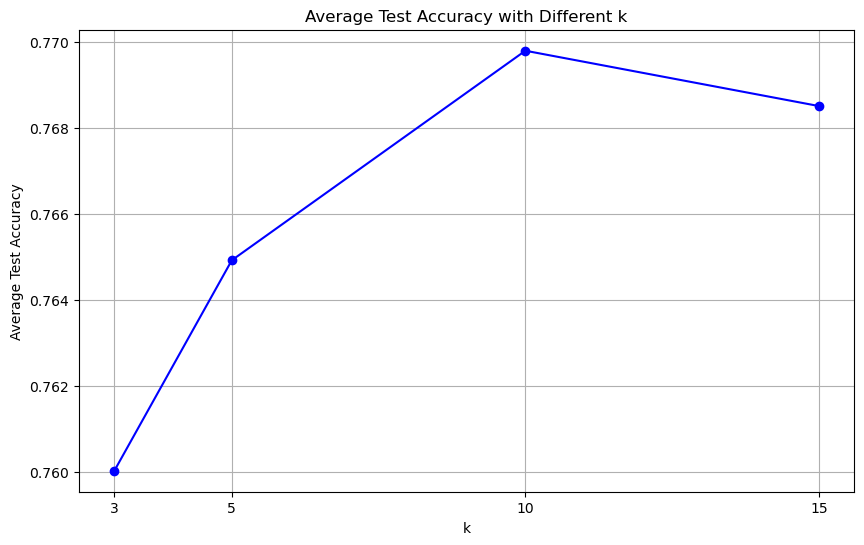

最优的k值为：10


In [2]:
import re
import cv2
import numpy as np
import raw_data_read_test as rd
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

def encode_label(label_list: list) -> (list, list):
    label_name = [[] for i in range(5)]

    label_encoded_list = []

    for label in label_list:
        if label is None:
            label_encoded_list.append(None)
            continue
        label_encoded = []

        for i in range(len(label) - 1):
            if not label[i] in label_name[i]:
                label_name[i].append(label[i])
                label_encoded.append(len(label_name[i]) - 1)
            else:
                label_encoded.append(label_name[i].index(label[i]))

        if label[4] is None:
            label_encoded.append([None])
        else:
            prop = []
            for ll in label[4]:
                if not ll in label_name[4]:
                    label_name[4].append(ll)
                    prop.append(len(label_name[4]) - 1)
                else:
                    prop.append(label_name[4].index(ll))
            label_encoded.append(prop)

        label_encoded_list.append(label_encoded)
    return label_name, label_encoded_list


def read_label(path: str) -> (list, list):
    label_list = []
    img_name = []
    with open(path, "r") as f:
        r = f.readline()
        while r:
            img_name.append(r[:5].strip())
            t = re.search('_missing descriptor', r)
            if t is not None:
                label_list.append(None)
                r = f.readline()
                continue
            else:
                label1 = []
                pattern = re.compile(r'\((.*?)\)')
                t = pattern.findall(r)
                for s in t[0:-1]:
                    c = s.split(" ")[-1].strip()
                    label1.append(c)

                pattern = re.compile(r'\'\((.*?)\)')
                t = pattern.findall(r)[0].strip()
                if not t == '':
                    prop = []
                    t = t.split(" ")
                    for i in t:
                        prop.append(i)
                    label1.append(prop)
                else:
                    label1.append(None)
            label_list.append(label1)
            r = f.readline()
    return label_list, img_name


def one_hot_prop(label_encoded_list: list, prop_num: int) -> list:
    label_list = []
    iii = 0
    for label in label_encoded_list:
        iii += 1
        if label is not None:
            prop_one_hot = [0 for i in range(prop_num)]
            prop = label.pop()
            for i in prop:
                if i is not None:
                    prop_one_hot[i] = 1
            label.append(prop_one_hot)
            label_list.append(label)
            if 1 in prop_one_hot:
                pass
        else:
            label_list.append(None)
    return label_list


def one_hot(index, num):
    label_one_hot = [0 for i in range(num)]
    label_one_hot[index] = 1
    return label_one_hot


def one_hot_label(label_list: list, label_name) -> list:
    label_one_hot = []
    for label in label_list:
        if label is not None:
            l = []
            for i in range(len(label_name) - 1):
                o = one_hot(label[i], len(label_name[i]))
                l += o
            l += label[-1]
        else:
            label_one_hot.append(None)
            continue
        label_one_hot.append(l)
    return label_one_hot


def label_pre_one_hot(path1, path2):
    label_list1, img_name1 = read_label(path1)
    # print(len(img_name1))
    label_list2, img_name2 = read_label(path2)
    # print(len(img_name2))
    label_list = label_list1 + label_list2

    male = 0
    total = 0

    # for label in label_list:
    #     if label is not None:
    #         total += 1
    #         if label[0] == 'male':
    #             male += 1
    # print(male, total)

    img_name = img_name1 + img_name2
    label_name, label_encoded_list = encode_label(label_list)
    prop_num = len(label_name[-1])
    label_list = one_hot_prop(label_encoded_list, prop_num)
    label_one_hot = one_hot_label(label_list, label_name)

    return label_one_hot, img_name, label_name
# raw_data_read_test, path_rawdata, path_label1, path_label2

# 训练集
channels = 1  # 图像的通道数，灰度图为1
path_rawdata = r"./rawdata"
path_label1 = r"./faceDR"
path_label2 = r"./faceDS"
label_one_hot, img_name, label_list = label_pre_one_hot(path_label1, path_label2)
img_list = rd.read_rawdata(channels, path_rawdata, img_name)  # 图片矩阵

# 数据预处理
n = 0
for i in range(len(label_list)):
    num = i - n
    if label_list[num] is None:
        del label_list[num]
        del img_name[num]
        n += 1

array_of_img = []
for img in img_list:
    if img is not None:
        img = img / 255.0
        img = cv2.resize(img, (100, 100))
        array_of_img.append(img)
train_images = np.array(array_of_img)

array_of_labels = []
for label in label_one_hot:
    if label is not None:
        append_label = label[0]
        array_of_labels.append(int(append_label))
train_labels = np.array(array_of_labels)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=3)

# 特征降维
pca = PCA(n_components=85)
newX = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
xx = pca.transform(X_test.reshape(X_test.shape[0], -1))

# 定义模型
tree = DecisionTreeClassifier(criterion="entropy", random_state=80, max_depth=15)  # 决策树
tree.fit(newX, y_train)
knn = KNeighborsClassifier(n_neighbors=1)  # knn
knn.fit(newX, y_train)
svm = SVC()  # svm
svm.fit(newX, y_train)

kfold = KFold(n_splits=10)

# 评估模型
knn_scores = cross_val_score(knn, newX, y_train, cv=kfold)
print("knn Accuracy: %0.2f (+/- %0.2f)" % (knn_scores.mean(), knn_scores.std() * 2))

svm_scores = cross_val_score(svm, newX, y_train, cv=kfold)
print("svm Accuracy: %0.2f (+/- %0.2f)" % (svm_scores.mean(), svm_scores.std() * 2))

tree_scores = cross_val_score(tree, newX, y_train, cv=kfold)
print("tree Accuracy: %0.2f (+/- %0.2f)" % (tree_scores.mean(), tree_scores.std() * 2))

# 画出不同参数下的决策树模型性能结果
# 绘制不同k值下的平均测试准确率
k_values = [3, 5, 10, 15]
mean_accuracies_k = []

for k in k_values:
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    tree = DecisionTreeClassifier(criterion="entropy", random_state=80, max_depth=15)
    scores = cross_val_score(tree, newX, y_train, cv=kfold)
    mean_accuracies_k.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_accuracies_k, marker='o', linestyle='-', color='b')
plt.title('Average Test Accuracy with Different k')
plt.xlabel('k')
plt.ylabel('Average Test Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()



最优的k值为：10


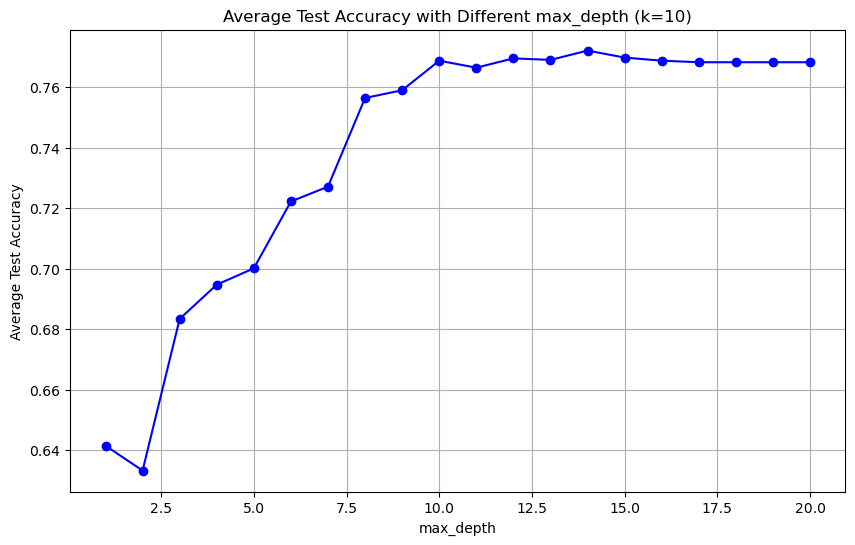

In [ ]:
# 选出最优的k值
best_k = k_values[np.argmax(mean_accuracies_k)]
print(f"最优的k值为：{best_k}")

# 绘制不同max_depth值下的平均测试准确率
max_depths = range(1, 21)
mean_accuracies_depth = []
for depth in max_depths:
    kfold = KFold(n_splits=best_k, shuffle=True, random_state=42)
    tree = DecisionTreeClassifier(criterion="entropy", random_state=80, max_depth=depth)
    scores = cross_val_score(tree, newX, y_train, cv=kfold)
    mean_accuracies_depth.append(scores.mean())

plt.figure(figsize=(10, 6))
plt.plot(max_depths, mean_accuracies_depth, marker='o', linestyle='-', color='b')
plt.title(f'Average Test Accuracy with Different max_depth (k={best_k})')
plt.xlabel('max_depth')
plt.ylabel('Average Test Accuracy')
plt.grid(True)
plt.show()


# 创建决策树,用网格搜索和交叉验证找最优参数并拟合数据
def fit_model_k_fold(X, y):
    k_fold = KFold(n_splits=best_k)
    clf = DecisionTreeClassifier(random_state=80)
    params = {'max_depth': range(1, 21), 'criterion': ['entropy', 'gini']}
    scoring_fnc = make_scorer(accuracy_score)
    grid = GridSearchCV(clf, param_grid=params, scoring=scoring_fnc, cv=k_fold)
    grid = grid.fit(X, y)
    return grid.best_estimator_

clf = fit_model_k_fold(newX, y_train)
print("k_fold Parameter 'max_depth' is {} for the optimal model.".format(clf.get_params()['max_depth']))
print("k_fold Parameter 'criterion' is {} for the optimal model.".format(clf.get_params()['criterion']))
score = clf.score(xx, y_test)
print('最优参数的决策树训练准确率：', score * 100, '%')